In [1]:
spark.version

'3.0.1'

In [2]:
import os
import shutil
from itertools import islice
import requests

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [3]:
import json
from itertools import combinations, takewhile
import collections

from google.cloud import storage
import io

import pandas as pd

pd.set_option("max_colwidth", 100)

In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
!hadoop fs -du -s -h "gs://msca-bdp-tweets/final_project"

156.2 G  156.2 G  gs://msca-bdp-tweets/final_project


In [7]:
%%time
tweets_df = spark.read.json("gs://msca-bdp-tweets/final_project")

CPU times: user 37.4 ms, sys: 18.3 ms, total: 55.7 ms
Wall time: 4min 15s


## Discard irrelevant tweets

In [8]:
tweets = tweets_df.select(["id","text","created_at","retweeted_status","user","place"]).\
withColumn("Text", lower(col('text'))).\
filter(col("Text").contains("covid")|
       col("Text").contains("social distance")|
       col("Text").contains("fomite")|
       col("Text").contains("distancing")|
       col("Text").contains("pandemic")|
       col("Text").contains("outbreak")|
       col("Text").contains("epidemic")|
       col("Text").contains("community spread")|
       col("Text").contains("contact tracing")|
       col("Text").contains("martial law")|
       col("Text").contains("quarantine")|
       col("Text").contains("index case")|
       col("Text").contains("index patient")|
       col("Text").contains("super-spreader")|
       col("Text").contains("isolation")|
       col("Text").contains("coronavirus")|
       col("Text").contains("virus")|
       col("Text").contains("infectious")|
       col("Text").contains("contagious")
      ).\
na.drop(subset=["id","text","created_at","user"]) #delete the location for larger size

In [10]:
%%time
tweets.count()

CPU times: user 47.5 ms, sys: 21.3 ms, total: 68.8 ms
Wall time: 3min 54s


15448267

## Complete thorough EDA to identify which variables you can use to profile the Twitterers A lot of variables are poorly populated and will have to be discarded

In [9]:
tweets = tweets.withColumn("User_location", lower(tweets["user"].getItem("location"))).\
  withColumn("User_verified", tweets["user"].getItem("verified")).\
  withColumn("User_id", tweets["user"].getItem("id")).\
  withColumn("User_name", tweets["user"].getItem("name")).\
  withColumn("User_description", lower(tweets["user"].getItem("description"))).\
  drop("user")

In [10]:
tweets = tweets.withColumn("Week",substring("created_at",1,3)).\
    withColumn("Date",substring("created_at",5,6)).\
    withColumn("Hour",substring("created_at",12,2)).\
    withColumn("Time",substring("created_at",12,8)).\
    drop("created_at")

In [11]:
tweets = tweets.withColumn("Organization",\
           when((col("User_verified") == True) & (col("User_description").contains("gov")), "government entities").\
           when((col("User_verified") == True) & (col("User_description").contains("prime minister")), "government entities").\
           when((col("User_verified") == True) & (col("User_description").contains("health")), "health organizations").\
           when((col("User_verified") == True) & (col("User_description").contains("new")), "news outlets").\
           when(col("User_verified") == True, "social media influencers").\
           otherwise("someone else")).drop("User_verified")

In [12]:
tweets = tweets.withColumn("retweeted_id", tweets["retweeted_status"].getItem("id")).\
         withColumn("retweeted_user_id", tweets["retweeted_status"].getItem("user").getItem("id")).\
         withColumn("retweeted_count", tweets["retweeted_status"].getItem("retweet_count")).\
         withColumn("original_or_not",\
           when(col("retweeted_id").isNull(), True).\
           otherwise(False)).drop("retweeted_status")

In [13]:
tweets = tweets.withColumn("location_name", tweets["place"].getItem("name")).\
withColumn("location_country", tweets["place"].getItem("country")).\
withColumn("place_type", tweets["place"].getItem("place_type")).\
withColumn("coordinates", tweets["place"].getItem("bounding_box").getItem("coordinates")).\
drop("place")

In [14]:
tweets = tweets.withColumn("latitude",tweets["coordinates"][0][0][0]).\
    withColumn("longitude",tweets["coordinates"][0][0][1]).\
    drop("coordinates")

In [15]:
tweets.printSchema()

root
 |-- id: long (nullable = true)
 |-- Text: string (nullable = true)
 |-- User_location: string (nullable = true)
 |-- User_id: long (nullable = true)
 |-- User_name: string (nullable = true)
 |-- User_description: string (nullable = true)
 |-- Week: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Hour: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Organization: string (nullable = false)
 |-- retweeted_id: long (nullable = true)
 |-- retweeted_user_id: long (nullable = true)
 |-- retweeted_count: long (nullable = true)
 |-- original_or_not: boolean (nullable = false)
 |-- location_name: string (nullable = true)
 |-- location_country: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



## Identify the most prolific / influential Twitterers
* By message volume (original content)
* By message retweet (how often their messages are being retweeted)
* Who are these Twitterers (government entities / health organizations / news outlets / social media influencers / someone else)?
* Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

#### By message volume (original content)

In [17]:
twitters = tweets.filter(col("original_or_not") == True).\
groupby(['User_id']).\
agg(count("id"),first("User_name"),first("Organization")).\
withColumnRenamed('first(User_name)', 'User_name').\
withColumnRenamed('count(id)', 'Volume').\
withColumnRenamed('first(Organization)', 'Organization').\
orderBy('Volume', ascending=False).\
dropna()

In [ ]:
%%time
twitters.show(5)

+-------------------+------+---------------+------------+
|            User_id|Volume|      User_name|Organization|
+-------------------+------+---------------+------------+
|         3219670842| 15349|  Nathan Joyner|someone else|
|          728894570|  4742|    iWeller.com|someone else|
|1283765688616628233|  4681|       Galla Go|someone else|
|1269612893529444354|  4510|       News Bht|someone else|
|1015456945447170048|  4333|hiremaid.com.sg|someone else|
+-------------------+------+---------------+------------+
only showing top 5 rows

CPU times: user 94.8 ms, sys: 22.7 ms, total: 117 ms
Wall time: 6min 27s


In [ ]:
%%time

twitters_plot = twitters.\
groupby(['Organization']).\
agg(sum("Volume")).\
withColumnRenamed('sum(Volume)', 'Volume').\
toPandas()

CPU times: user 95.6 ms, sys: 41 ms, total: 137 ms
Wall time: 6min 1s


In [22]:
twitters_plot

,Organization,Volume
0,someone else,4163722
1,social media influencers,105491
2,health organizations,23959
3,government entities,11757
4,news outlets,148724


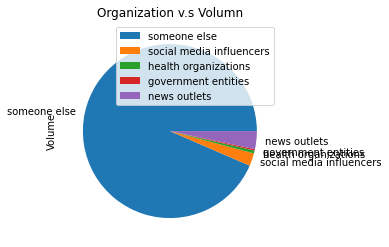

In [24]:
my_plot = twitters_plot.plot(kind='pie',x='Organization', y='Volume', title="Organization v.s Original_Tweets_Volumn",labels = ["someone else","social media influencers","health organizations","government entities","news outlets"])

#### By message retweet (how often their messages are being retweeted)

In [16]:
%%time

retweet_twitters = tweets.filter(col("original_or_not") == False).\
groupby(['retweeted_id']).\
agg(max("retweeted_count"),first("retweeted_user_id")).\
withColumnRenamed('max(retweeted_count)', 'retweeted_count').\
withColumnRenamed('first(retweeted_user_id)', 'retweeted_user_id').\
orderBy('retweeted_user_id', ascending=True).\
dropna()

CPU times: user 11.8 ms, sys: 1.52 ms, total: 13.3 ms
Wall time: 128 ms


In [ ]:
retweet_twitters.show(10)

+-------------------+---------------+-----------------+
|       retweeted_id|retweeted_count|retweeted_user_id|
+-------------------+---------------+-----------------+
|1247616214769086465|          71512|               12|
|1451680546875076608|              1|              259|
|1450047828244455431|              2|              280|
|1449064447356530691|             27|              586|
|1450072748970053637|              7|              767|
|1450097548929032197|             29|              767|
|1453865869839200259|              5|              767|
|1452440736998166530|              1|              785|
|1456776413139197954|              1|              785|
|1451421149087207430|              1|              785|
+-------------------+---------------+-----------------+
only showing top 10 rows



In [17]:
retweet_user_count = retweet_twitters.\
groupby(['retweeted_user_id']).\
agg(sum("retweeted_count")).\
withColumnRenamed('sum(retweeted_count)', 'retweeted_count')

In [ ]:
retweet_user_count.show(10)

+-------------------+---------------+
|  retweeted_user_id|retweeted_count|
+-------------------+---------------+
|          917191800|            346|
|1413052170308444161|          11272|
|          494701047|             18|
| 954603262627389441|              1|
|           84063737|           1320|
|          257618490|              5|
|           43301934|              2|
|          631810714|            582|
|           19073744|             12|
|           14384185|              1|
+-------------------+---------------+
only showing top 10 rows



In [18]:
original_twitters = tweets.filter(col("original_or_not") == True).\
groupby(['User_id']).\
agg(first("User_name"),first("Organization")).\
withColumnRenamed('first(User_name)', 'User_name').\
withColumnRenamed('first(Organization)', 'Organization').\
dropna()

In [19]:
twitter_retweet = retweet_user_count.\
join(original_twitters, retweet_user_count.retweeted_user_id == original_twitters.User_id,how='right').\
drop("retweeted_user_id").\
orderBy('retweeted_count', ascending=False).\
dropna()

In [20]:
%%time

twitter_retweet.show(10)

+---------------+-------------------+-------------------+--------------------+
|retweeted_count|            User_id|          User_name|        Organization|
+---------------+-------------------+-------------------+--------------------+
|         431198| 707231479047315456|        PeterSweden|social media infl...|
|         418509|           18831926|    Eric Feigl-Ding|health organizations|
|         400338|           39844876|Robert W Malone, MD|        someone else|
|         378544|1349149096909668363|    President Biden| government entities|
|         248354|           18839785|      Narendra Modi| government entities|
|         244047|          878284831|   Occupy Democrats|social media infl...|
|         229281|           15392486|        Disclose.tv|        someone else|
|         227598| 878247600096509952|      Candace Owens|        news outlets|
|         226194|             939091|          Joe Biden|social media infl...|
|         221184|          933128688|   Curtis Armst

In [ ]:
%%time

twitter_retweet.count()

CPU times: user 99 ms, sys: 18.4 ms, total: 117 ms
Wall time: 10min 9s


309752

In [ ]:
%%time

twitters_plot = twitter_retweet.\
groupby(['Organization']).\
agg(sum("retweeted_count")).\
withColumnRenamed('sum(retweeted_count)', 'Retweet_Volume').\
toPandas()

CPU times: user 159 ms, sys: 55.7 ms, total: 215 ms
Wall time: 11min 56s


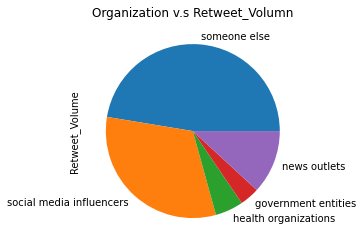

In [30]:
my_plot = twitters_plot.plot(kind='pie',x='Organization', y='Retweet_Volume', legend=None, title="Organization v.s Retweet_Volumn",labels = ["someone else","social media influencers","health organizations","government entities","news outlets"])

## Where are these Twitterers (all of them, not just influencers) located?
* Do you see any relationship between the pandemic progression and locations of these Twitterers?
* Visualize the geographical distribution

https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b

### Ways one

In [32]:
location = tweets.\
groupby(['User_id']).\
agg(count("id"),first("User_name"),first("User_location")).\
withColumnRenamed('count(id)', 'Volume').\
withColumnRenamed('first(User_name)', 'User_name').\
withColumnRenamed('first(User_location)', 'Location').\
dropna().\
filter(col("Location").contains(", ")).\
orderBy('Volume', ascending=False)

In [33]:
%%time

location.show(10)

+-------------------+------+--------------------+--------------------+
|            User_id|Volume|           User_name|            Location|
+-------------------+------+--------------------+--------------------+
|         3219670842| 15349|       Nathan Joyner|     los angeles, ca|
|          480875170|  2764|VonVictor Valenti...|        new york, ny|
|          283604227|  2582|        Andy Vermaut|   diksmuide, belgië|
|         2742938653|  2265|           HubBucket|        new york, ny|
|1142770687679111168|  2018| Qamar Afzaal Bhatti|    lahore, pakistan|
| 858595409060655104|  1896|              Skatiq|rustenburg, south...|
|           70300794|  1628|HellsBells #Unite...|scotland, united ...|
|          192969056|  1561|Workout Solutions...|toronto, canada  ...|
|          383589707|  1539|Top Most Popular ...|       mumbai, india|
|         2863762227|  1515|         GUINEE TAGS|       paris, france|
+-------------------+------+--------------------+--------------------+
only s

In [34]:
%%time

location.count()

CPU times: user 74.8 ms, sys: 5.91 ms, total: 80.7 ms
Wall time: 4min 45s


997596

In [39]:
Location_plot = location.groupby(["Location"]).\
agg(count("User_id")).\
withColumnRenamed('count(User_id)', 'Volume').\
orderBy('Volume', ascending=False).\
limit(15).toPandas()

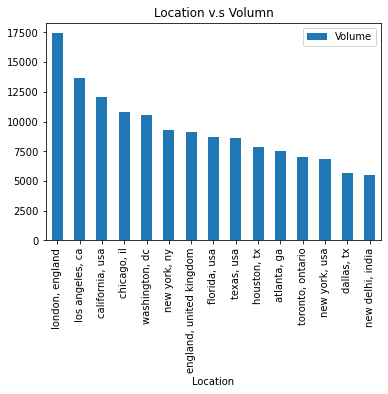

In [40]:
my_plot = Location_plot.plot(kind='bar',x='Location', y='Volume', title="Location v.s Volumn")

### Ways two 

In [41]:
%%time

location_name = tweets.groupby(['location_name']).\
agg(count("id")).\
withColumnRenamed('count(id)', 'Volume').\
orderBy('Volume', ascending=False).\
dropna().\
limit(15).\
toPandas()

CPU times: user 45.3 ms, sys: 25.8 ms, total: 71.1 ms
Wall time: 3min 18s


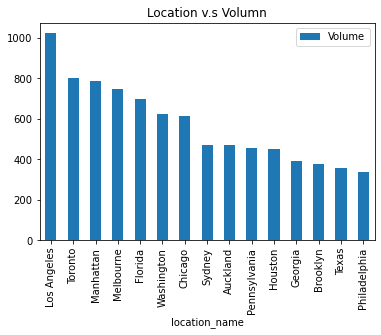

In [43]:
my_plot = location_name.plot(kind='bar',x='location_name', y='Volume', title="Location v.s Volumn")

In [ ]:
%%time

location_point = tweets.groupby(["latitude","longitude"]).\
agg(count("id")).\
withColumnRenamed('count(id)', 'Volume').\
orderBy('Volume', ascending=False).\
dropna().\
toPandas()

CPU times: user 194 ms, sys: 24.7 ms, total: 219 ms
Wall time: 3min 35s


In [59]:
location_point.head(10)

,latitude,longitude,Volume
0,-118.668404,33.704538,1023
1,-79.639319,43.403221,802
2,-74.026675,40.683935,762
3,144.593742,-38.433859,729
4,-87.634643,24.396308,695
5,-87.940033,41.644102,612
6,-77.119401,38.801826,531
7,174.161834,-37.292621,476
8,150.520929,-34.118347,471
9,-80.519851,39.719801,453


In [71]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
geo = [Point(xy) for xy in zip(location_point["latitude"],location_point["longitude"])]

In [73]:
geo_df = gpd.GeoDataFrame(location_point, geometry = geo)

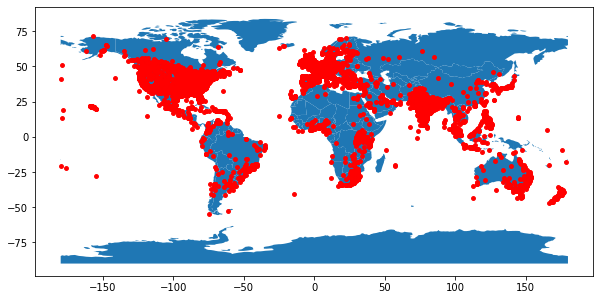

In [79]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_df.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## What are the timelines of these tweets? Do you see significant peaks and valleys?
* Do you see any data collection gaps?
* Plot the timelines of these tweets

In [ ]:
%%time
date = tweets.\
groupby(['Date']).\
agg(count("id")).\
withColumnRenamed('count(id)', 'Volume').\
orderBy('Date', ascending=True).\
dropna().\
toPandas()

CPU times: user 30.3 ms, sys: 4.35 ms, total: 34.6 ms
Wall time: 1min 47s


In [84]:
date["Date"] = date.Date.apply(lambda x: '11/' + x[4:6] if 'Nov' in x else x)
date["Date"] = date.Date.apply(lambda x: '10/' + x[4:6] if 'Oct' in x else x)

In [90]:
date = date.sort_values(by = ["Date"], ascending = True)

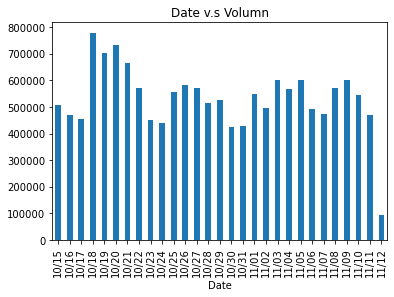

In [92]:
my_plot = date.plot(kind='bar',x='Date', y='Volume', legend=None, title="Date v.s Volumn")

In [110]:
covid = pd.read_csv("gs://msca-bdp-students-bucket/shared_data/dongniy/cumulative-deaths-and-cases-covid-19.csv")

In [111]:
covid['Day'] = pd.to_datetime(covid['Day'])
covid_project_1 =covid[(covid['Day'] > '2021-10-13') & (covid['Day'] <= "2021-11-11")]
covid_project_2 =covid[(covid['Day'] > '2021-10-14') & (covid['Day'] <= "2021-11-12")]
covid_project_1 = covid_project_1.groupby(['Day'])['Total confirmed deaths due to COVID-19',"Total confirmed cases of COVID-19"].agg('sum')
covid_project_2 = covid_project_2.groupby(['Day'])['Total confirmed deaths due to COVID-19',"Total confirmed cases of COVID-19"].agg('sum')
covid_project_1['Date'] = covid_project_1.index
covid_project_1.index = range(len(covid_project_1))
covid_project_2['Date'] = covid_project_2.index
covid_project_2.index = range(len(covid_project_2))
covid_project_2["death"] = covid_project_2["Total confirmed deaths due to COVID-19"]-covid_project_1["Total confirmed deaths due to COVID-19"]
covid_project_2["case"] = covid_project_2["Total confirmed cases of COVID-19"]-covid_project_1["Total confirmed cases of COVID-19"]
covid_project_2.head(5)

,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,Date,death,case
0,36130679.0,1.797581e+09,2021-10-15,53380.0,3387721.0
1,36169067.0,1.800102e+09,2021-10-16,38388.0,2520528.0
2,36200466.0,1.802444e+09,2021-10-17,31399.0,2342426.0
3,36248265.0,1.805508e+09,2021-10-18,47799.0,3063631.0
4,36308840.0,1.808805e+09,2021-10-19,60575.0,3297016.0


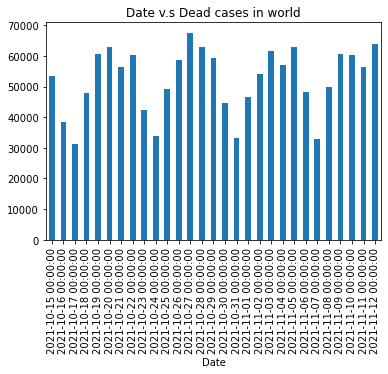

In [112]:
my_plot = covid_project_2.plot(kind='bar',x='Date', y='death', legend=None, title="Date v.s Dead cases in world")

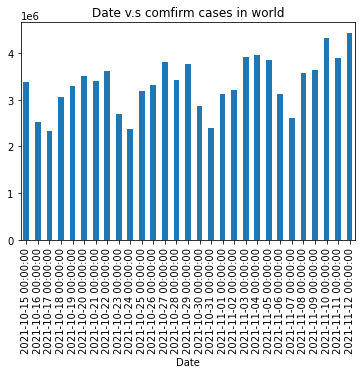

In [113]:
my_plot = covid_project_2.plot(kind='bar',x='Date', y='case', legend=None, title="Date v.s comfirm cases in world")

In [ ]:
%%time
hour = tweets.\
groupby(['Hour']).\
agg(count("id")).\
withColumnRenamed('count(id)', 'Volume').\
orderBy('Hour', ascending=True).\
dropna().\
toPandas()

CPU times: user 56.5 ms, sys: 15 ms, total: 71.4 ms
Wall time: 5min 7s


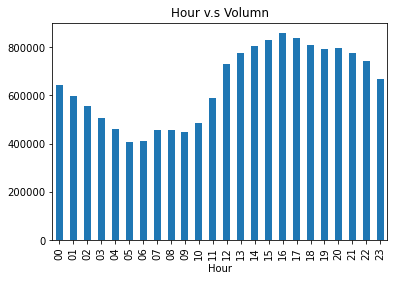

In [94]:
my_plot = hour.plot(kind='bar',x='Hour', y='Volume', legend=None, title="Hour v.s Volumn")

In [ ]:
%%time
week = tweets.\
groupby(['Week']).\
agg(count("id")).\
withColumnRenamed('count(id)', 'Volume').\
orderBy('Week', ascending=True).\
dropna().\
toPandas()

CPU times: user 45.8 ms, sys: 13.2 ms, total: 59 ms
Wall time: 5min 48s


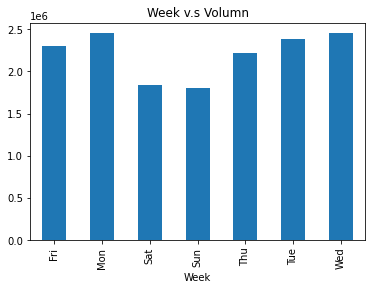

In [116]:
my_plot = week.plot(kind='bar',x='Week', y='Volume', legend=None, title="Week v.s Volumn")

## How unique are the messages?
* Are they mostly unique? Or usually people are just copy-pasting the same text?
* You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
* Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)
* Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis.

In [16]:
together = tweets.\
select(["id","text"]).\
dropna().limit(5000)

In [17]:
%%time

text = together.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

CPU times: user 1.4 ms, sys: 4.21 ms, total: 5.61 ms
Wall time: 1.49 s


In [18]:
%%time
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text',"id"])

CPU times: user 29 ms, sys: 9.27 ms, total: 38.3 ms
Wall time: 1min 18s


In [19]:
%%time
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull()).dropna()

CPU times: user 13.8 ms, sys: 14.6 ms, total: 28.4 ms
Wall time: 1.76 s


In [20]:
%%time
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

CPU times: user 13.6 ms, sys: 4.24 ms, total: 17.9 ms
Wall time: 5.2 s


In [21]:
%%time
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

CPU times: user 17.8 ms, sys: 6.05 ms, total: 23.8 ms
Wall time: 221 ms


In [22]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

In [23]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [24]:
records = df_hashed_text.count()
print ('Total records: ', records)

Total records:  5000


In [25]:
%%time
dups = df_dups_text.select('id_A').distinct().count()
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)

Duplicate titles based on { 0.7 } jaccard distance:  2216
CPU times: user 90.4 ms, sys: 28.5 ms, total: 119 ms
Wall time: 1min 40s


In [26]:
uniques = records - dups

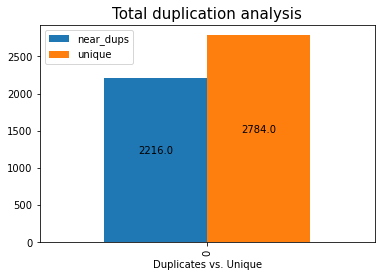

In [27]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Total duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### Government

In [31]:
government = tweets.filter(col("Organization") == "government entities").\
select(["id","text"]).\
dropna()

In [32]:
%%time

text = government.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

CPU times: user 256 ms, sys: 101 ms, total: 357 ms
Wall time: 2min 33s


In [33]:
%%time
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text',"id"])

CPU times: user 257 ms, sys: 111 ms, total: 368 ms
Wall time: 2min 11s


In [113]:
%%time
df_text.limit(5).show()

+--------------------+----+
|                text|  id|
+--------------------+----+
|[rt @samirsaran: ...|6013|
|[need your covid ...|6014|
|[havering residen...|6015|
|[rt @edconwaysky:...|6016|
|[rt @easternhealt...|6017|
+--------------------+----+

CPU times: user 245 ms, sys: 83.1 ms, total: 328 ms
Wall time: 1min 42s


In [41]:
%%time
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull()).dropna().limit(3000)

CPU times: user 16 ms, sys: 8.19 ms, total: 24.2 ms
Wall time: 1.9 s


In [35]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [42]:
%%time
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

CPU times: user 239 ms, sys: 113 ms, total: 352 ms
Wall time: 2min 33s


In [43]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [44]:
df_hashed.count()

3000

In [139]:
df_hashed.limit(3).toPandas()

,list_of_words,id,features,hashes
0,"[share, #myvaccination, story, and, raise, awareness, about, covid-19, and, vaccines, using, social, media, resources:, ➡️ …, https://t.co/29vvnblvbb]",16719,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[18678956.0], [1206064039.0], [195383692.0], [208791553.0], [355808799.0]]"
1,"[rt, @govuk:, stop, covid-19, hanging, around, \ncovid-19, hangs, in, the, air, like, smoke, so, open, windows, to, clear, it, away, 🦠🪟]",16720,"(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...)","[[47945584.0], [110296106.0], [30854182.0], [345118765.0], [62905716.0]]"
2,"[floridians, are, beating, covid, and, building, our, economic, back, despite, @govrondesantis,, not, because, of, him.]",16721,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...)","[[283091598.0], [265552235.0], [287775359.0], [76317376.0], [23594946.0]]"


In [48]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'right')

In [46]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [ ]:
records = df_hashed_text.count()
print ('Total records: ', records)

Total records:  3000


In [ ]:
%%time
dups = df_dups_text.select('id_A').distinct().count()
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)

Duplicate titles based on { 0.7 } jaccard distance:  977
CPU times: user 512 ms, sys: 234 ms, total: 746 ms
Wall time: 5min 15s


In [51]:
uniques = records - dups

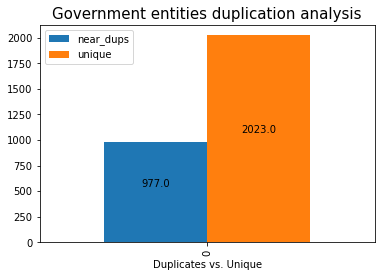

In [53]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Government entities duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### Health

In [95]:
health = tweets.filter(col("Organization") == "health organizations").\
select(["id","text"]).\
dropna().\
limit(3000)

In [96]:
%%time

text = health.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

CPU times: user 3.28 ms, sys: 0 ns, total: 3.28 ms
Wall time: 368 ms


In [97]:
%%time
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text',"id"])

CPU times: user 24.8 ms, sys: 9.89 ms, total: 34.7 ms
Wall time: 2min 27s


In [98]:
%%time
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull()).dropna()

CPU times: user 16.2 ms, sys: 2.35 ms, total: 18.5 ms
Wall time: 1.33 s


In [99]:
%%time
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

CPU times: user 14.2 ms, sys: 4.72 ms, total: 18.9 ms
Wall time: 2.95 s


In [100]:
%%time
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

CPU times: user 10.3 ms, sys: 3.02 ms, total: 13.4 ms
Wall time: 56.3 ms


In [101]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

In [104]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [105]:
records = df_hashed_text.count()

print ('Total records: ', records)
#print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
#print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3000


In [106]:
%%time
dups = df_dups_text.select('id_A').distinct().count()
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)

Duplicate titles based on { 0.7 } jaccard distance:  681
CPU times: user 62 ms, sys: 24.9 ms, total: 86.9 ms
Wall time: 28.8 s


In [29]:
uniques = records - dups

In [ ]:
uniques

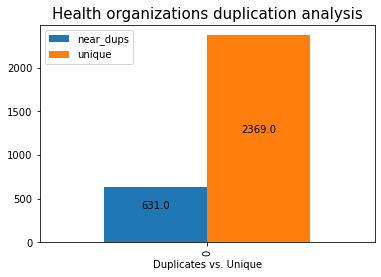

In [30]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Health organizations duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### News outlets 

In [57]:
new = tweets.filter(col("Organization") == "news outlets").\
select(["id","text"]).\
dropna().\
limit(3000)

In [58]:
%%time

text = new.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

CPU times: user 2.61 ms, sys: 865 µs, total: 3.48 ms
Wall time: 392 ms


In [59]:
%%time
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text',"id"])

CPU times: user 28.2 ms, sys: 10.8 ms, total: 39.1 ms
Wall time: 2min 29s


In [60]:
%%time
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull()).dropna()

CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 1.29 s


In [61]:
%%time
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

CPU times: user 15.2 ms, sys: 4.85 ms, total: 20 ms
Wall time: 4.31 s


In [62]:
%%time
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

CPU times: user 17.4 ms, sys: 16 µs, total: 17.4 ms
Wall time: 102 ms


In [63]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

In [64]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [65]:
records = df_hashed_text.count()

print ('Total records: ', records)

Total records:  3000


In [66]:
%%time
dups = df_dups_text.select('id_A').distinct().count()
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)

Duplicate titles based on { 0.7 } jaccard distance:  730
CPU times: user 62.2 ms, sys: 33.8 ms, total: 96 ms
Wall time: 24.4 s


In [67]:
uniques = records - dups

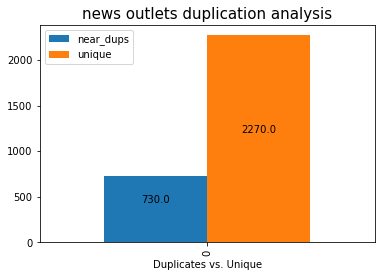

In [68]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title("news outlets duplication analysis", fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### Social media influencers

In [70]:
media = tweets.filter(col("Organization") == "social media influencers").\
select(["id","text"]).\
dropna().\
limit(3000)

In [71]:
%%time

text = media.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

CPU times: user 2.47 ms, sys: 809 µs, total: 3.28 ms
Wall time: 345 ms


In [72]:
%%time
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text',"id"])

CPU times: user 34.2 ms, sys: 2.82 ms, total: 37 ms
Wall time: 2min 33s


In [73]:
%%time
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull()).dropna()

CPU times: user 8.08 ms, sys: 12.8 ms, total: 20.9 ms
Wall time: 1.28 s


In [74]:
%%time
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

CPU times: user 16 ms, sys: 1.99 ms, total: 17.9 ms
Wall time: 4.15 s


In [75]:
%%time
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 73 ms


In [76]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

In [77]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [78]:
records = df_hashed_text.count()
print ('Total records: ', records)

Total records:  3000


In [79]:
%%time
dups = df_dups_text.select('id_A').distinct().count()
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)

Duplicate titles based on { 0.7 } jaccard distance:  472
CPU times: user 69.4 ms, sys: 18.7 ms, total: 88.2 ms
Wall time: 23.7 s


In [80]:
uniques = records - dups

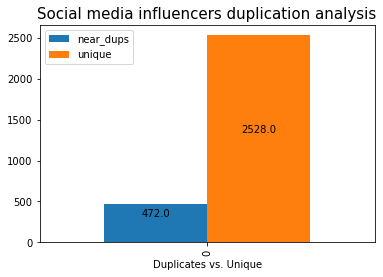

In [81]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title("Social media influencers duplication analysis", fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### Someone else

In [53]:
someone_else = tweets.filter(col("Organization") == "someone else").\
select(["id","text"]).\
dropna().\
limit(3000)

In [54]:
%%time

text = someone_else.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

CPU times: user 3.43 ms, sys: 0 ns, total: 3.43 ms
Wall time: 378 ms


In [55]:
%%time
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text',"id"])

CPU times: user 28.4 ms, sys: 10.1 ms, total: 38.5 ms
Wall time: 1min 58s


In [56]:
%%time
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull()).dropna()

CPU times: user 22.7 ms, sys: 336 µs, total: 23 ms
Wall time: 135 ms


In [57]:
%%time
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

CPU times: user 12.3 ms, sys: 7.58 ms, total: 19.9 ms
Wall time: 4.27 s


In [58]:
%%time
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

CPU times: user 12.4 ms, sys: 4.12 ms, total: 16.5 ms
Wall time: 68.2 ms


In [59]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

In [60]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [62]:
records = df_hashed_text.count()
print ('Total records: ', records)

Total records:  3000


In [63]:
%%time
dups = df_dups_text.select('id_A').distinct().count()
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)

Duplicate titles based on { 0.7 } jaccard distance:  1194
CPU times: user 79.5 ms, sys: 32.5 ms, total: 112 ms
Wall time: 43.7 s


In [64]:
uniques = records - dups

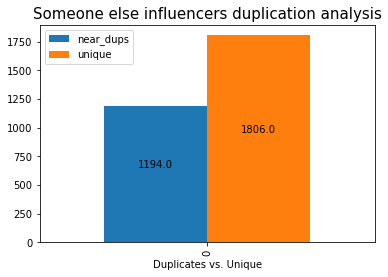

In [65]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title("Someone else influencers duplication analysis", fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')